# Nested sampling for bayesian analysis of phases distributions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from emcee import autocorr

## Import phases from file on disk

Th file has rows with 16 different columns, one for each measured phase.
The number of rows is the number of lattice configurations used for the measurements.

In [2]:
N = 16
S = 24

In [3]:
data_folder = f"/Users/enrythebest/Dropbox (University of Michigan)/Projects/PD/EK_v14/N{N}M{N}/S{S}/T029/P025/"

In [4]:
import os
os.listdir(data_folder)

['input_v14.dat',
 'EK_D3N16M16S24T0290P025_phase_2.txt',
 'output.log',
 'EK_D3N16M16S24T0290P025_phase_1.txt',
 'EK_D3N16M16S24T0290P025_1.txt',
 'EK_D3N16M16S24T0290P025_2.txt',
 'EK_D3N16M16S24T0290P025_1.dat',
 'EK_D3N16M16S24T0290P025_2.dat']

### Summary file

In [5]:
cols = ["tj", "pc", "dH", "pdec", "pcon", "e", "w", "acc"]

In [6]:
summary_name = f"EK_D3N{N}M{N}S{S}T0290P025_2.txt"

The files generated on Hokusai come from an executable compiled with `ifort` instead of `gfortran`. This allows some speed up on Intel chips, but the way Masanori writes all his Fortran codes means that the output files will be different, unfortunately. This could be avoided by specifying the format of the `WRITE` statements in Fortran.

For now we have to endure the hassle and read the different format where each line is broken into multiple lines...

In [7]:
with open(data_folder+summary_name) as fp:
    lines = fp.readlines()

The first 14 lines can be skipped (it is the header). Alternativelt, skip the lines with the `#` comment sign

In [8]:
print(f"The file has a total of {len(lines)} lines")

The file has a total of 15015 lines


Skip the first 14 lines of header, then grab the rows in blocks of n=3 and transform the input strings to numbers

In [9]:
def row(lst, n):
    """Grab successive n-sized chunks from list of lines in file and return a numerical array of elements"""
    rows = []
    for i in np.arange(0, len(lst), n):
        one_line = ' '.join(lst[i:i + n]).strip().split()
        rows.append(list(map(float, one_line)))
    return np.asarray(rows)

* Test it:

In [10]:
test_line = lines[15:18]
print(row(test_line,3))

[[1.00000000e+01 0.00000000e+00 1.59097683e-02 2.46162694e-01
  0.00000000e+00 3.59952264e+01 4.28602386e-02 7.00000000e-01]]


* This is the content of one line

In [11]:
one_line = ' '.join(test_line).strip().split()

In [12]:
one_line

['10',
 '0',
 '1.590976825173129E-002',
 '0.246162694318502',
 '0.000000000000000E+000',
 '35.9952264379209',
 '4.286023860894705E-002',
 '0.700000000000000']

* Transform to numbers

In [13]:
one_line_num = list(map(float, one_line))

In [14]:
np.asarray(one_line_num)

array([1.00000000e+01, 0.00000000e+00, 1.59097683e-02, 2.46162694e-01,
       0.00000000e+00, 3.59952264e+01, 4.28602386e-02, 7.00000000e-01])

### Do it for all the lines

In [15]:
# summary = pd.read_csv(data_folder+summary_name, sep="\s+", skiprows=14, names=cols, header=None)

In [15]:
data_from_summary = row(lines[15:],3)

In [16]:
data_from_summary.shape

(5000, 8)

In [17]:
summary = pd.DataFrame(data=data_from_summary, columns=cols)

In [18]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tj      5000 non-null   float64
 1   pc      5000 non-null   float64
 2   dH      5000 non-null   float64
 3   pdec    5000 non-null   float64
 4   pcon    5000 non-null   float64
 5   e       5000 non-null   float64
 6   w       5000 non-null   float64
 7   acc     5000 non-null   float64
dtypes: float64(8)
memory usage: 312.6 KB


We can look at some of the autocorrelation times

In [20]:
tau = autocorr.integrated_time(summary.e, tol=0)
print(f"Action autocorrelation integrated time: {tau[0]:.2f}")
tau = autocorr.integrated_time(summary.w, tol=0)
print(f"|Wilson| autocorrelation integrated time: {tau[0]:.2f}")

Action autocorrelation integrated time: 1.26
|Wilson| autocorrelation integrated time: 1.08


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

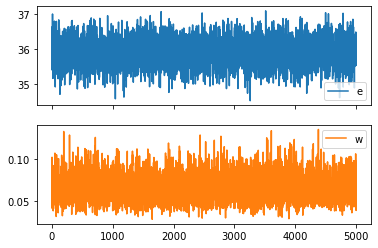

In [21]:
summary[["e","w"]].plot(subplots=True)

### Phase file

In [20]:
phase_name = f"EK_D3N{N}M{N}S{S}T0290P025_phase_2.txt"

In [23]:

# phases = pd.read_csv(data_folder+phase_name, sep="\s+", header=None)


In [21]:
with open(data_folder+phase_name) as fp:
    lines = fp.readlines()

In [22]:
# for the phases file of N=16, we skip no lines and grab chunks of 6 lines
data_from_phases = row(lines,6)

In [23]:
data_from_phases.shape

(5000, 16)

In [24]:
phases = pd.DataFrame(data=data_from_phases)

In [25]:
phases.columns = [f"theta{i}" for i in phases.columns]

* We can concatenate multiple files

In [26]:
# phases_more = pd.read_csv(data_folder+phase_name.replace('_10','_9'), sep="\s+", header=None)

In [30]:
# phases_more.columns = [f"theta{i}" for i in phases_more.columns]

In [31]:
# concatenate and reindex from 0 to the total number of measurements
# phases = pd.concat((phases,phases_more),ignore_index=True)

In [27]:
phases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   theta0   5000 non-null   float64
 1   theta1   5000 non-null   float64
 2   theta2   5000 non-null   float64
 3   theta3   5000 non-null   float64
 4   theta4   5000 non-null   float64
 5   theta5   5000 non-null   float64
 6   theta6   5000 non-null   float64
 7   theta7   5000 non-null   float64
 8   theta8   5000 non-null   float64
 9   theta9   5000 non-null   float64
 10  theta10  5000 non-null   float64
 11  theta11  5000 non-null   float64
 12  theta12  5000 non-null   float64
 13  theta13  5000 non-null   float64
 14  theta14  5000 non-null   float64
 15  theta15  5000 non-null   float64
dtypes: float64(16)
memory usage: 625.1 KB


In [28]:
phases.sample(2)

,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,theta11,theta12,theta13,theta14,theta15
3241,2.950417,0.479348,1.375324,0.146089,-1.583144,1.068060,-0.637350,-0.021539,-2.040708,-0.299570,2.187858,1.694014,-2.511474,-0.914811,0.729723,-1.233754
1269,-1.521957,1.618215,-2.967313,1.144400,-0.367573,2.571195,0.354068,0.922625,-0.872067,0.504529,-1.845965,-2.196044,-1.049973,0.017605,1.811256,-0.127962


<AxesSubplot:>

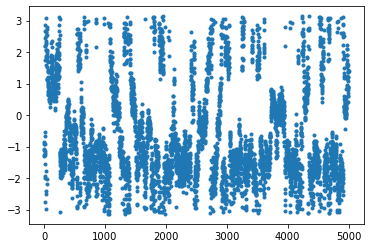

In [29]:
phases['theta0'].plot(linestyle='',marker='.')

<AxesSubplot:>

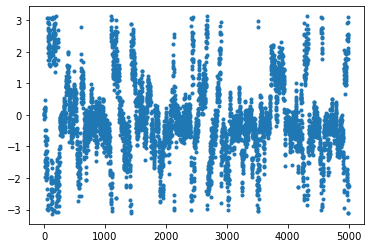

In [30]:
phases['theta15'].plot(linestyle='',marker='.')

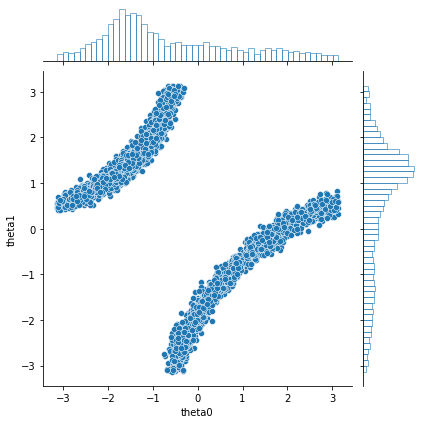

In [31]:
sns.jointplot(x='theta0', y='theta1', data=phases, marginal_kws=dict(bins=50, fill=False))

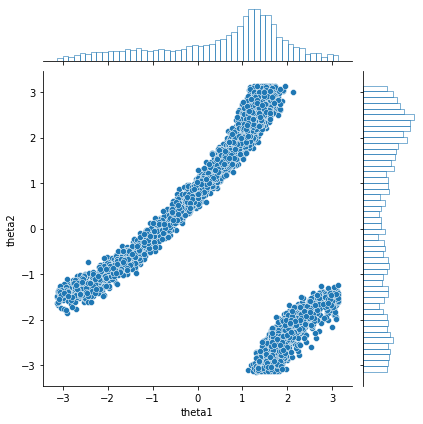

In [32]:
sns.jointplot(x='theta1', y='theta2', data=phases, marginal_kws=dict(bins=50, fill=False))

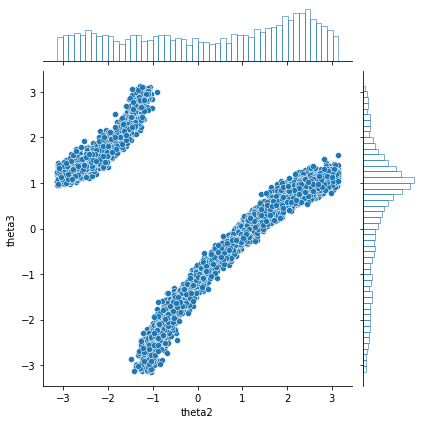

In [33]:
sns.jointplot(x='theta2', y='theta3', data=phases, marginal_kws=dict(bins=50, fill=False))

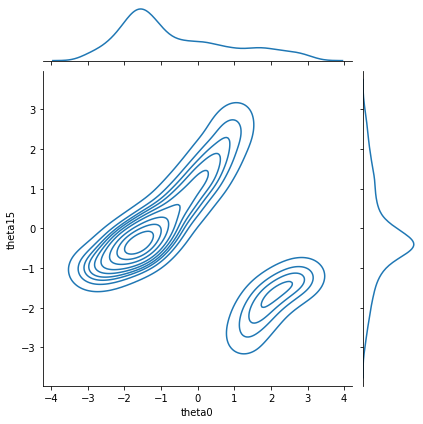

In [34]:
sns.jointplot(x='theta0', y='theta15', data=phases, kind='kde')

As long as N is not too large, we can make a pair plot (look at the interactions of all phases with each other). It is a bit expensive

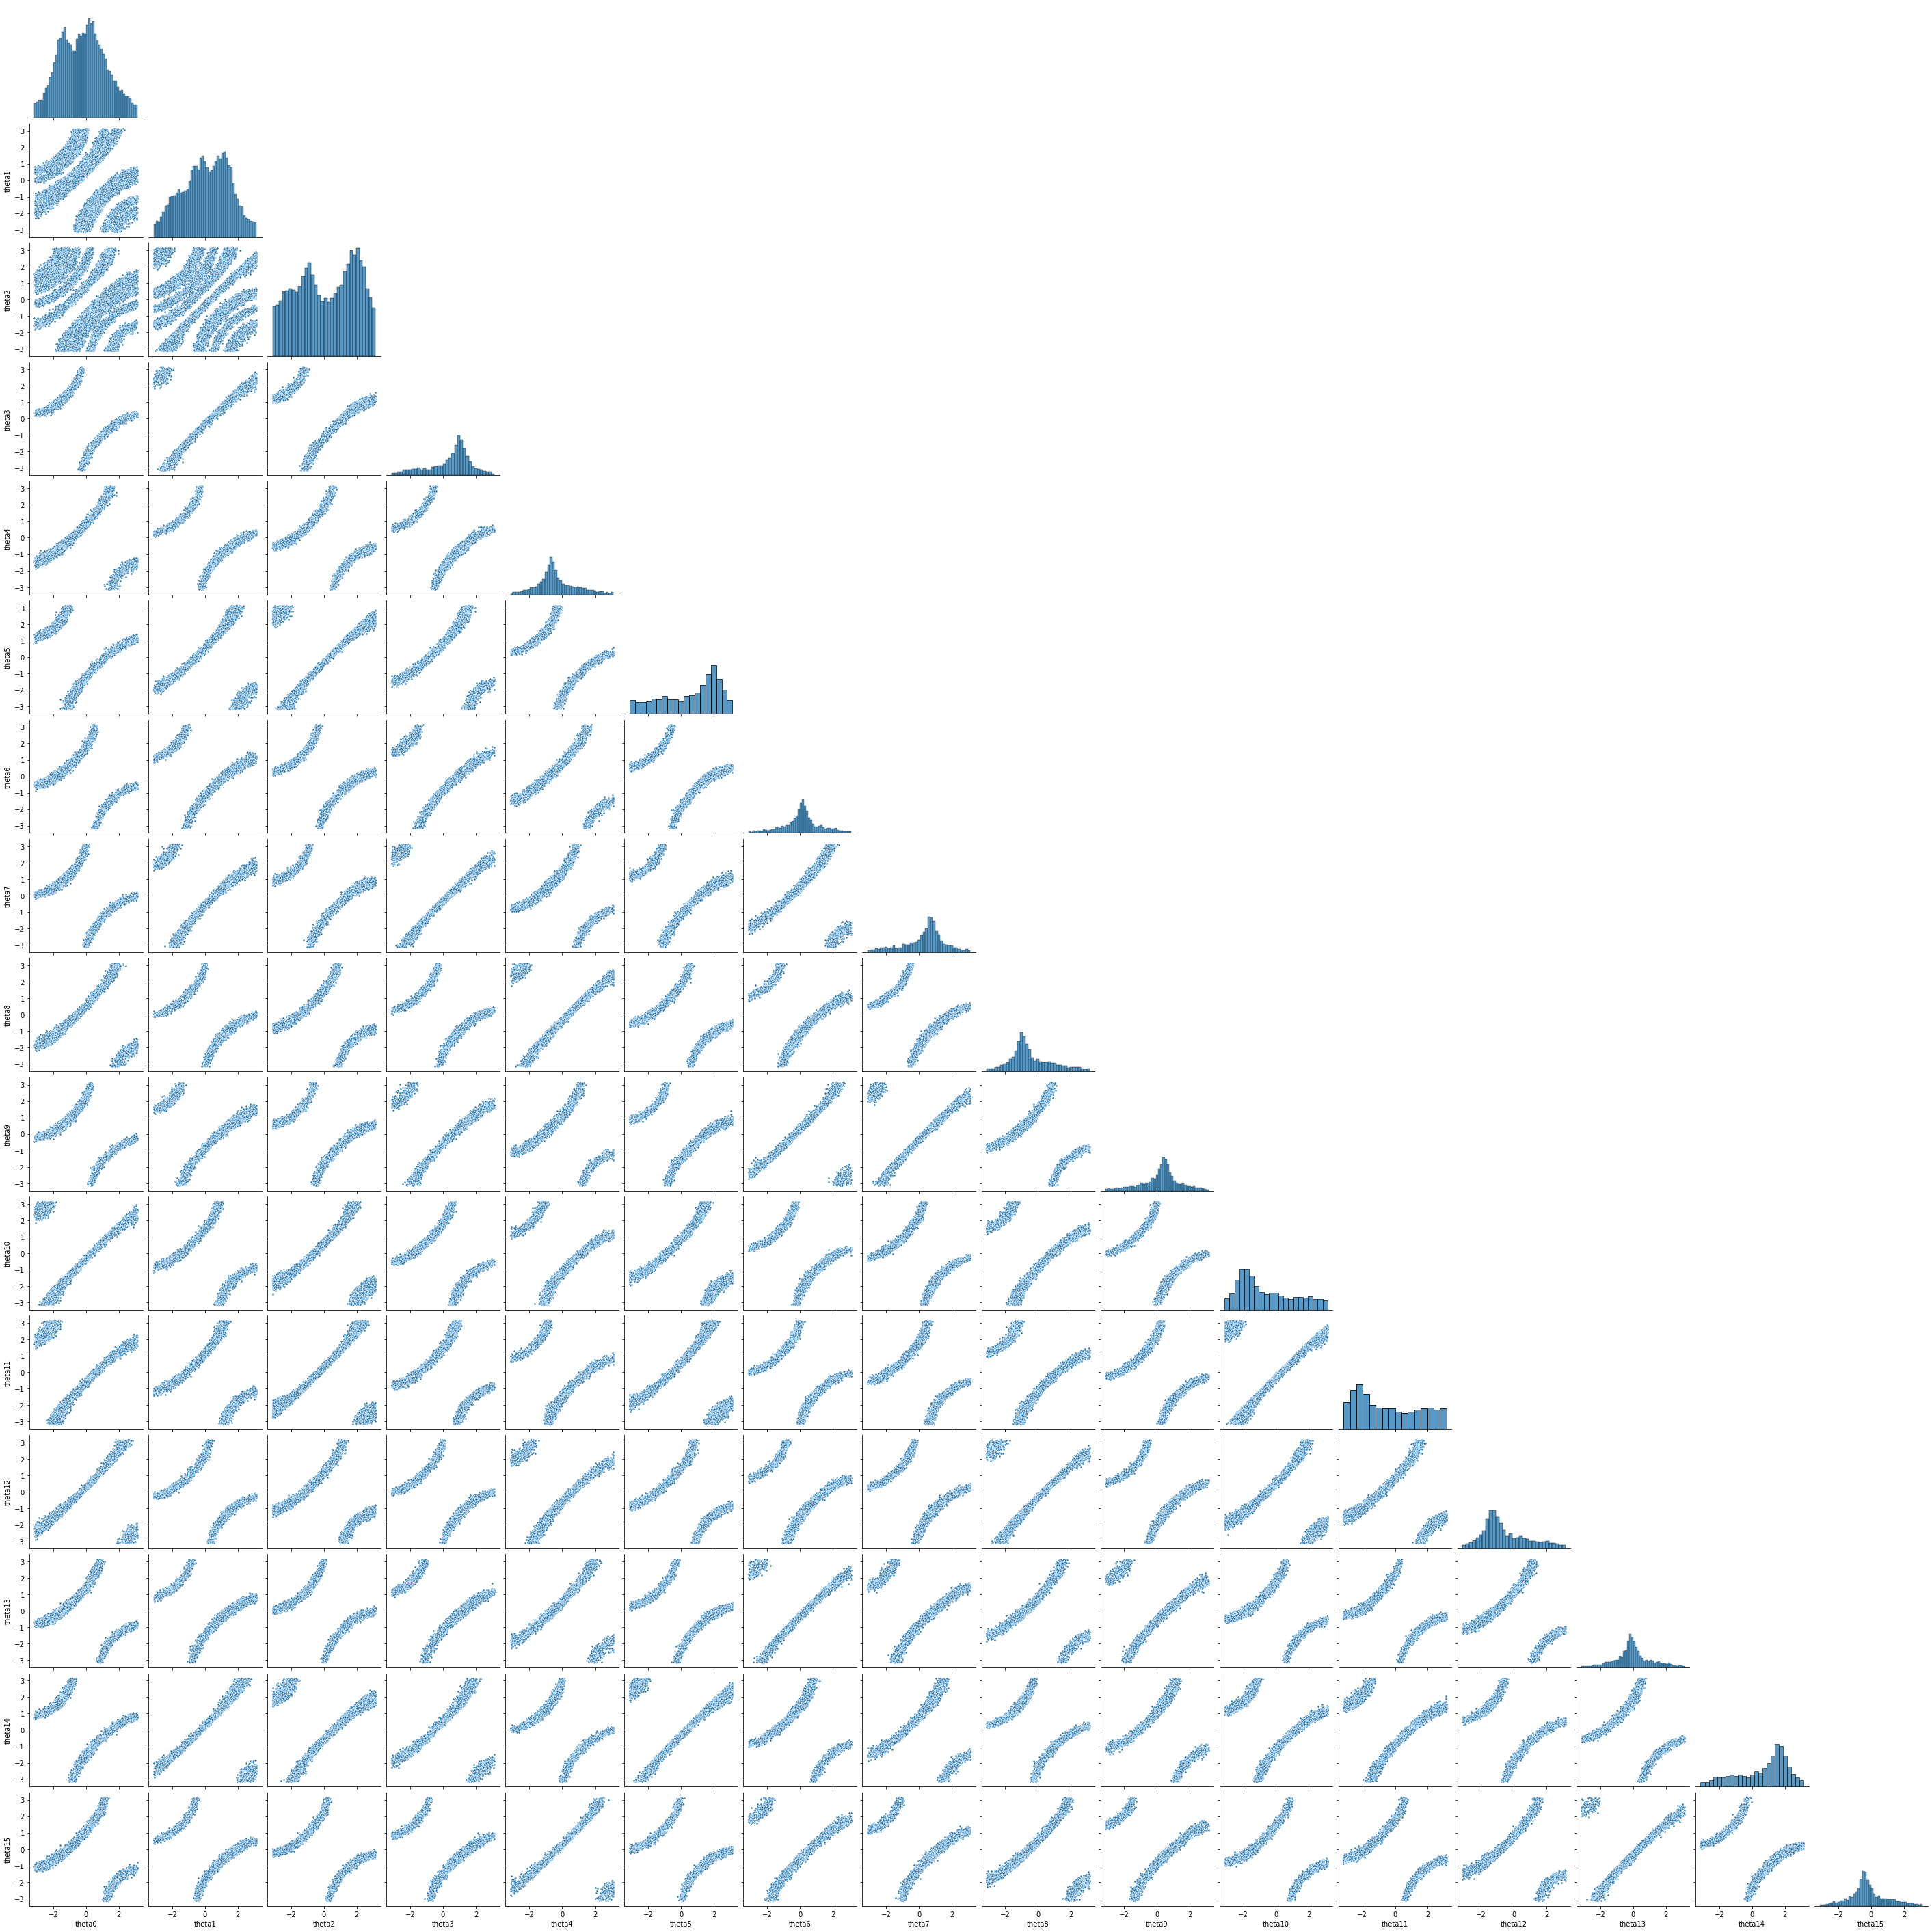

In [40]:
sns.pairplot(data=phases, corner=True, kind='scatter', diag_kind='hist', markers='.')

Create an histogram for entire dataset of phases. Here we can also choose to apply cuts for thermalization or select measurements with a certain frequency

In [35]:
freq = 2
thermcut = 0

In [36]:
alphas = phases.iloc[thermcut::freq].values.flatten()

In [37]:
print(f"We have a total of {alphas.shape[0]} phases")

We have a total of 40000 phases


Fold the distribution by taking the absolute value

In [38]:
alphas_folded = np.fabs(alphas)

<AxesSubplot:ylabel='Count'>

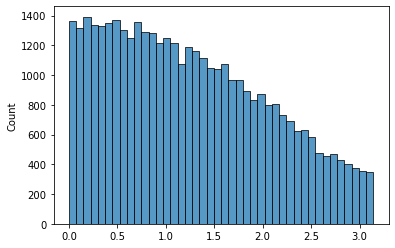

In [39]:
sns.histplot(data=alphas_folded)

<AxesSubplot:ylabel='Density'>

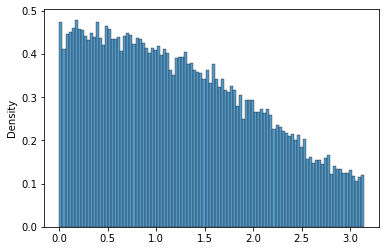

In [40]:
sns.histplot(data=alphas_folded, bins=100, stat='density')

Effects ot different bandwidths when doing kernel density estimations with a mixture of gaussians

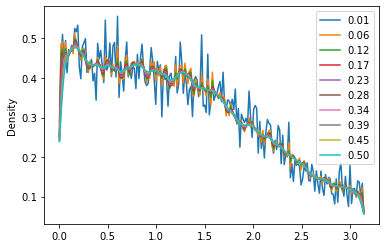

In [47]:
fig, ax = plt.subplots()
for bw in np.linspace(0.01,0.5,10):
  sns.kdeplot(data=alphas_folded, cut=0, clip=[0.0,np.pi], bw_adjust=bw, label=f"{bw:.2f}", ax=ax)
plt.legend(loc='upper right')

## Fit the probability distribution based on Fourier expansion

We use this as our model for the probability distribution of $\alpha$ with unknown coefficients $\tilde{\rho}_k$:

$$\rho(\alpha)=\frac{1}{2 \pi}+\sum_{k=1}^{\infty} \tilde{\rho}_{k} \cos (k \alpha)$$

Choose the number of parameters and their names based on how many Fourier coefficients to keep:

In [97]:
Nf = 2  # number of Fourier coefficient
parameters = [f"k{i+1}" for i in np.arange(Nf)]

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    params = cube.copy()
    # all parameters should around 0: change the limits if needed
    lo = -0.1
    hi = 0.1
    params[:] = cube[:] * (hi - lo) + lo
    return params

In [98]:
parameters

['k1', 'k2']

Define the model above

In [50]:
alpha = np.random.rand(10)
params = np.random.rand(Nf)
fourier_terms = np.array([params[k]*np.cos((k+1)*alpha) for k in np.arange(Nf)])

In [51]:
fourier_terms.shape

(5, 10)

In [52]:
prob = fourier_terms.sum(axis=0)+1./(2.*np.pi)

In [53]:
if (prob < 0).any():
  print("Some are negative")

Some are negative


Make sure to only keep positive probabilities

In [99]:
def prob_model(alpha,params):
  fourier_terms = np.array([params[k]*np.cos((k+1)*alpha) for k in np.arange(Nf)])
  prob = 1./(2.*np.pi) + fourier_terms.sum(axis=0)  # the k=0 term is 1/2pi
  if (prob < 0).any():  # if some probs are negative, the total prob is 0
    return np.zeros_like(prob)
  return prob

In [55]:
prob_model(np.random.rand(1),np.random.rand(Nf))

array([1.19940932])

In [56]:
prob_model(np.random.rand(2),np.random.rand(Nf))

array([1.56120382, 2.60703397])

This likelihood ignores the correlations between differen $\alpha$ values. We define it as:

$$ \mathcal{L} \propto \prod_{n=1}^{n_{\text {config }}} \prod_{i=1}^{N} \rho\left(\alpha_{i}^{(n)}\right) $$

In [100]:
def log_likelihood(params):
    # compute the probability for each alpha point
    probs_alphas = prob_model(alphas,params)
    assert probs_alphas.shape[0] == alphas.shape[0]
    # the total probability is the product of the individual ones, we assume independent
    # for numerical stability, we work in log and avoid zeros
    loglike = np.log(probs_alphas + 1e-100).sum()
    return loglike

The log-likelihood is often ridiculously small (and negative) because the probabilities are zero hence the sum of logs is -$\infty$

In [58]:
log_likelihood(np.random.rand(Nf))

-64472382.60383333

If all parameters are set to zero, the probabilities do not depend on the data and are always equal to $1/2\pi$. This gives the following log-likelihood

In [59]:
log_likelihood(np.zeros(Nf))

nan

We can check if that is correct

In [60]:
# number of alphas
n_data = alphas.shape[0]
loglik = np.log([1/(2*np.pi)]*n_data).sum()
print(loglik)

-514605.57859461696


### Run the sampler

Define the reactive nested sampler

In [101]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)

If needed you can add a slice sampler for a more efficient sampling in high dimensions

In [ ]:
# import ultranest.stepsampler

# # have to choose the number of steps the slice sampler should take
# # after first results, this should be increased and checked for consistency.

# nsteps = 2 * len(parameters)
# # create step sampler:
# sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=nsteps)

In [102]:
results = sampler.run(min_num_live_points=400)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+04  -70664.17 [-70664.1779..-70664.1779]*| it/evals=5080/7066 eff=75.9226% N=381  
[ultranest] Likelihood function evaluations: 7068
[ultranest]   logZ = -7.067e+04 +- 0.1035
[ultranest] Effective samples strategy satisfied (ESS = 1550.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.10 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.


### Plot results

In [103]:
sampler.print_results()


logZ = -70672.906 +- 0.273
  single instance: logZ = -70672.906 +- 0.139
  bootstrapped   : logZ = -70672.908 +- 0.273
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    k1                  : 0.0760│ ▁▁▁▁▁▁▁▁▂▂▂▃▃▄▆▇▇▆▇▇▇▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁ │0.0836    0.0798 +- 0.0010
    k2                  : -0.0206│ ▁ ▁▁▁▁▁▁▂▂▃▃▄▆▆▇▇▇▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁▁▁ ▁ │-0.0114    -0.0163 +- 0.0011



The result includes an estimate of the evidence `logZ` (or marginal likelihood) which tells us how probable the data is under this model. This is the strength of nested sampling methods. It allows us to discriminate between models. For example, we can run the code again with the same data but a different number of Fourier coefficients. The difference in `logZ` will tell us which model is favored by the data! (e.g. see [this tutotial](https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html))

Table of results:

 Model  | Evidence |
| ----- | ----------- |
| Nf = 5  |  logZ = -70674.178 +- 0.413 |
| Nf = 4  |  logZ = -70670.095 +- 0.315 |
| Nf = 3  |  logZ = -70667.004 +- 0.259 |
| Nf = 2  |  logZ = -70672.906 +- 0.273 |
| Nf = 1  |  logZ = -70781.606 +- 0.116 |

In [104]:
# result_nf5 = sampler
# result_nf4 = sampler
# result_nf3 = sampler
result_nf2 = sampler
# result_nf1 = sampler

In [116]:
logBF = result_nf3.results['logz'] - result_nf4.results['logz']
K = np.exp(logBF)
print(f"logBF = {logBF:.3f}")
print(f"K = {K:.3f}")
print(f"The first model is {K:.3f} times more probable than the second model")
print("assuming the models are equally probable a priori.")

logBF = 3.092
K = 22.011
The first model is 22.011 times more probable than the second model
assuming the models are equally probable a priori.


In [ ]:
sampler.results

{'niter': 6362,
 'logz': -226688.44608517207,
 'logzerr': 0.5380735679545979,
 'logz_bs': -226688.3574710077,
 'logz_single': -226688.44608517207,
 'logzerr_tail': 0.009922746306983754,
 'logzerr_bs': 0.5379820662783459,
 'ess': 1225.1829536233606,
 'H': 21.91799764786265,
 'Herr': 0.22588702227408775,
 'posterior': {'mean': [0.07952544716883513,
   -0.0145005170432576,
   0.00484481603281706,
   -0.002064184797092474,
   0.0005253156389633779],
  'stdev': [0.0005634592945943535,
   0.0006104889823021717,
   0.0006203217479003007,
   0.0006225953747175214,
   0.0005856387778030109],
  'median': [0.07953256849416021,
   -0.014525868844551038,
   0.004832706348251392,
   -0.002042873586350996,
   0.0005131595117503912],
  'errlo': [0.0789590020573013,
   -0.015094039555928848,
   0.004187414457552207,
   -0.002701435375045472,
   -3.554150322676586e-05],
  'errup': [0.08008657573886493,
   -0.013866369058034261,
   0.005482260547525986,
   -0.0014535073343163452,
   0.0011090505576649284

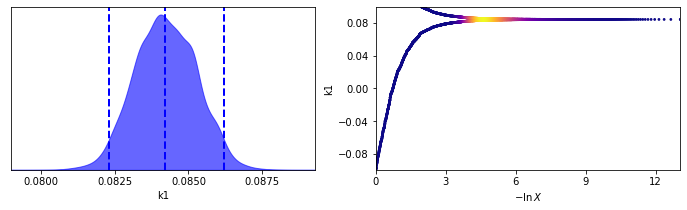

In [93]:
sampler.plot_trace()

In [94]:
from corner import corner
import arviz as az 
import xarray as xr 

df = pd.DataFrame(sampler.results['samples'], columns=parameters)
df["chain"] = 0
df["draw"] = np.arange(len(df), dtype=int)
df = df.set_index(["chain", "draw"])
xdata = xr.Dataset.from_dataframe(df)

dataset = az.InferenceData(posterior=xdata)

In [74]:
dataset

Inference data with groups:
	> posterior

<AxesSubplot:title={'center':'k1'}>

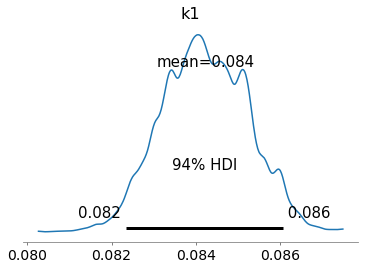

In [95]:
az.plot_posterior(dataset) # or choose only one parameter with var_names=['k1']

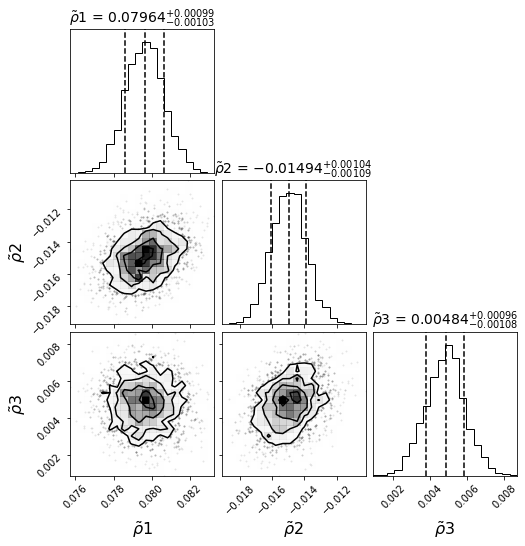

In [76]:
labels = [r"$\tilde{\rho}$" + f"{k+1}" for k in range(Nf)]
fig = corner(
    data=dataset,
    labels=labels,
    show_titles=True,
    title_fmt=".5f",
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 14},
    label_kwargs={"fontsize": 16},
)


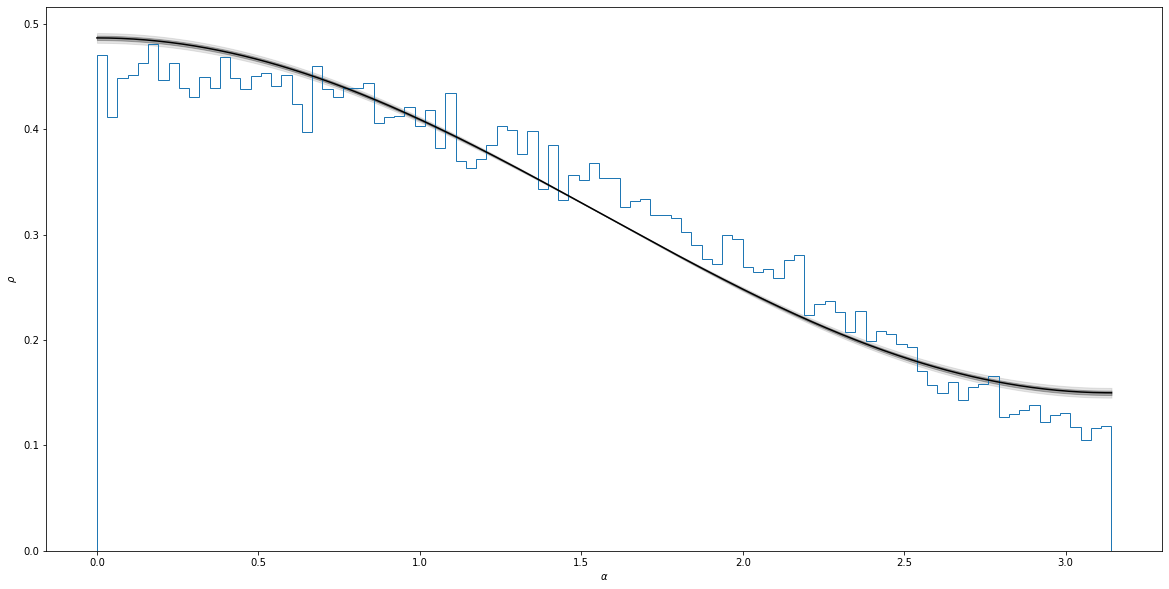

In [96]:
from ultranest.plot import PredictionBand
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\rho$')
bins = np.linspace(0, np.pi, 100)
plt.hist(alphas_folded,bins,density=True,histtype='step');

alpha_grid = np.linspace(0, np.pi, 500)
band = PredictionBand(alpha_grid)

# go through the solutions
for params in sampler.results['samples']:
    # compute for each time the probability from the model
    band.add(2*prob_model(alpha_grid,params))

# add central values
band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)


## Extract the value of $\rho$ at $\pi$

Point a $\pi$ 

In [ ]:
band.x[-1]-np.pi

0.0

Take all the samples at the value of $\pi$ (remember that we saved 2$\rho$ in the prediction band)

In [78]:
rhopi = np.asarray([rho[-1]/2 for rho in band.ys])

<AxesSubplot:ylabel='Density'>

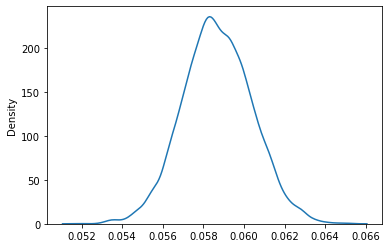

In [ ]:
sns.kdeplot(data=rhopi)

In [79]:
print(f"Value of rho(pi) = {rhopi.mean():.5f} +- {rhopi.std():.5f}")

Value of rho(pi) = 0.05976 +- 0.00138


In [80]:
errs = np.diff(np.quantile(rhopi,[0.16,0.5,0.84]))
print(f"Value of rho(pi) = {rhopi.mean():.5f} + {errs[1]:.5f} - {errs[0]:.5f}")

Value of rho(pi) = 0.05976 + 0.00144 - 0.00141


Pretty formatting

In [81]:
from IPython.display import display, Math

mcmc = np.percentile(rhopi, [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
txt = txt.format(mcmc[1], q[0], q[1], '\\rho(\pi)')
display(Math(txt))

<IPython.core.display.Math object>

Value of $M$: derived from the equation 
$$
\rho(\pi) = \frac{1}{2\pi} \left( 1 - \frac{M}{N} \right)
$$

In [82]:
M = N * (1. - 2 * np.pi * rhopi)
errs = np.diff(np.quantile(M,[0.16,0.5,0.84]))
print(f"Value of M = {M.mean():.5f} + {errs[1]:.5f} - {errs[0]:.5f}")

Value of M = 9.99275 + 0.14207 - 0.14505


In [83]:
mcmc = np.percentile(M, [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
txt = txt.format(mcmc[1], q[0], q[1], 'M')
display(Math(txt))

<IPython.core.display.Math object>